# Real Data Analyses

Words, words, words.

Notes:
- high dose: peak @ 0.5 Hz on frontal
    - keep in mind for filtering range & visualizations
- make sure to visualize time series and evaluate rhythms
- note limitations: fooof has trouble with the low frequency oscillations
- think about channels: show this?

In [1]:
import os
from pathlib import Path

from scipy.io import loadmat

# Import fooof functions
from fooof import FOOOF
from fooof.plts import plot_spectrum
from fooof.analysis import get_band_peak_fm

# Import neurodsp functions
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

## Load the Data

In [2]:
# Define the data path
data_path = Path('data')

In [3]:
# Get available data files
data_files_lst = [file for file in os.listdir(data_path) if '.mat' in file]
data_files_lst

['eeganes07laplac250_detrend_all_t180.mat',
 'eeganes07laplac250_detrend_all_t4710.mat',
 'eeganes07laplac250_detrend_all_t3070.mat']

### Data Information

EEG data from a healthy subject during propofol‑induced unconsciousness:
-  `eeganes07laplac250_detrend_all_t180.mat` Awake, before propofol induction
-  `eeganes07laplac250_detrend_all_t3070.mat` Unconscious, at a low dose of propofol
-  `eeganes07laplac250_detrend_all_t4710.mat` Unconscious, at a high dose of propofol

In [4]:
# Get
data_files_lst.sort()
data_files = {
    'awake' : data_files_lst[0],
    'low_dose' : data_files_lst[1],
    'high_dose' : data_files_lst[2],
}

### Load a Data File

In [35]:
# Set which data file to load (change here to run another file)
condition = 'awake'   # 'awake', 'low_dose', 'high_dose'

In [36]:
# Load a matfile with the data
matfile = loadmat(data_path / data_files[condition], squeeze_me=True)

In [37]:
# Check the data keys that are the matfile
matfile.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'egrid_1indexed', 'ta', 'y'])

In [38]:
# Extract data fields of interest
data = matfile['y'].T        # Data matrix - transpose to have channels as rows
fs = matfile['Fs']           # Sampling rate
times = matfile['ta']        # Times vector

# # 
# egrid_1indexed = matfile['egrid_1indexed']

In [39]:
# For simplicity, reset times vector to go from 0 to 30
times = times - times[0]

## Examine Data File

In [40]:
# Define channel index of interest
chind = 41

In [10]:
# 
channel_data = data[chind, :]

### Look at the time series

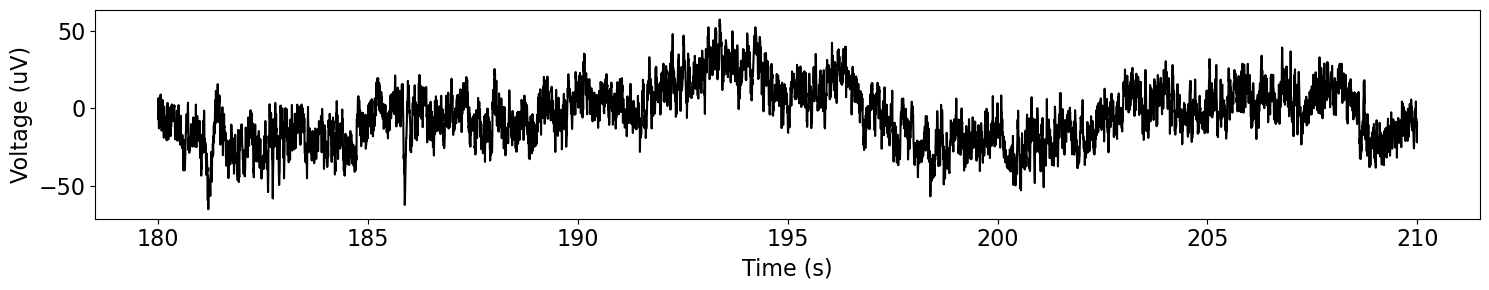

In [11]:
plot_time_series(times, channel_data)

### Compute power spectrum

In [12]:
# Define settings for estimating the power spectrum
psd_settings = {
    'nperseg' : 2 * fs, 
    'noverlap' : fs,
    'f_range' : [1, 100],
}

In [13]:
# Compute power spectrum
freqs, powers = compute_spectrum(channel_data, fs, **psd_settings)

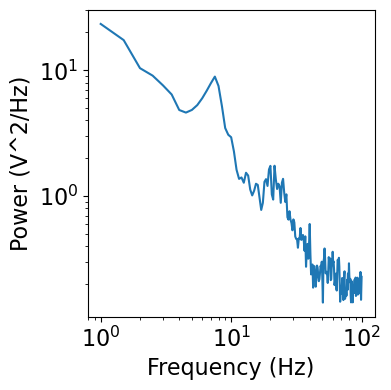

In [14]:
# Visualize power spectrum
plot_power_spectra(freqs, powers, figsize=(4, 4))

## Analyze the Data

### Parameterize the Spectrum

In [15]:
# Initialize spectral model
fm = FOOOF(peak_width_limits=[2, 8])

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          1.3900, 1.1314                                          
                                                                                                  
                                       4 peaks were found:                                        
          

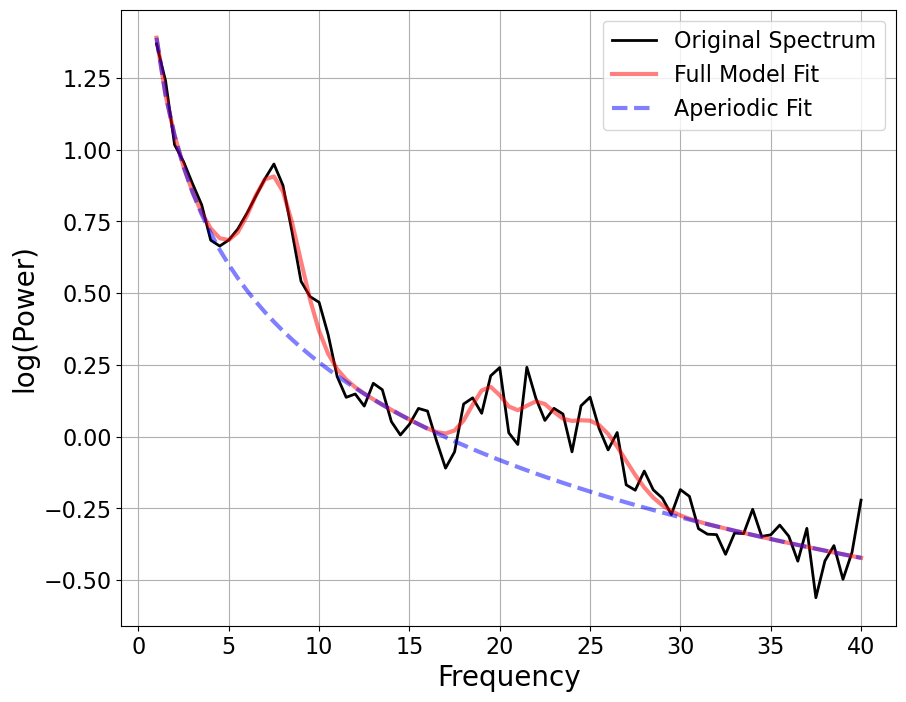

In [16]:
# Fit spectral model to the data
fm.report(freqs, powers, freq_range=[1, 40])

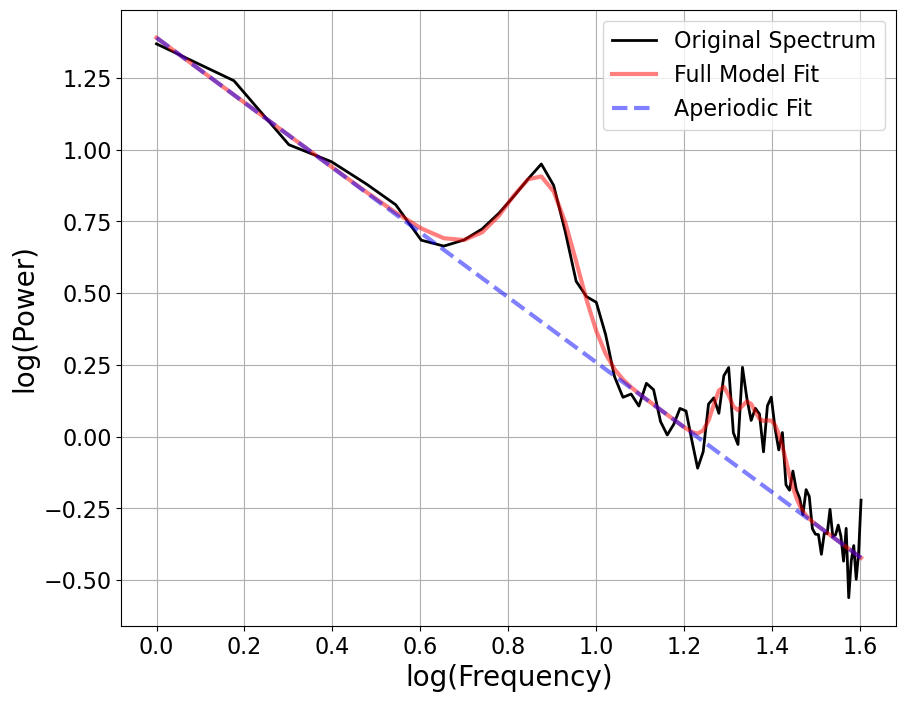

In [17]:
fm.plot(plt_log=True)

In [18]:
# Extract the dominant low frequency peak
get_band_peak_fm(fm, [1, 20])

array([7.59194178, 0.50666308, 2.74838349])

### Filter to the peak range

In [19]:
# 
#broadband = channel_data
broadband = filter_signal(channel_data, fs, 'bandpass', [0.5, 100], remove_edges=False)

In [20]:
#
narrowband = filter_signal(channel_data, fs, 'bandpass', [4, 12])

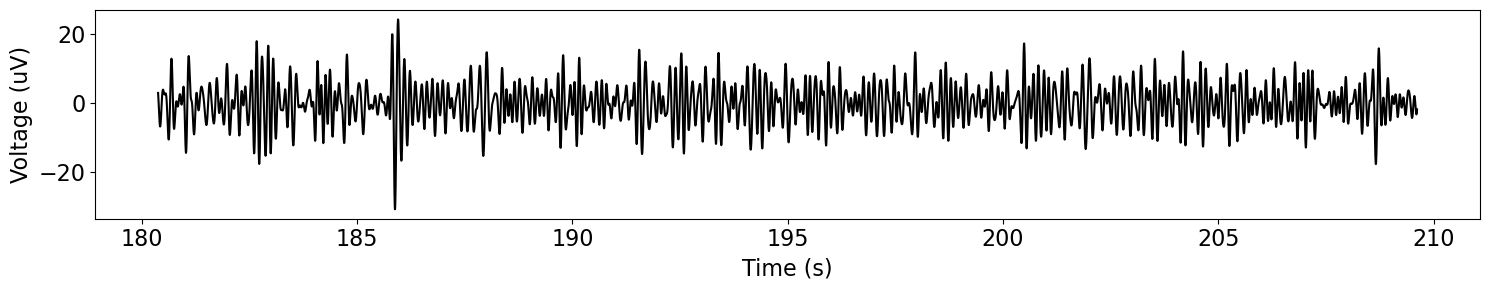

In [21]:
plot_time_series(times, narrowband)

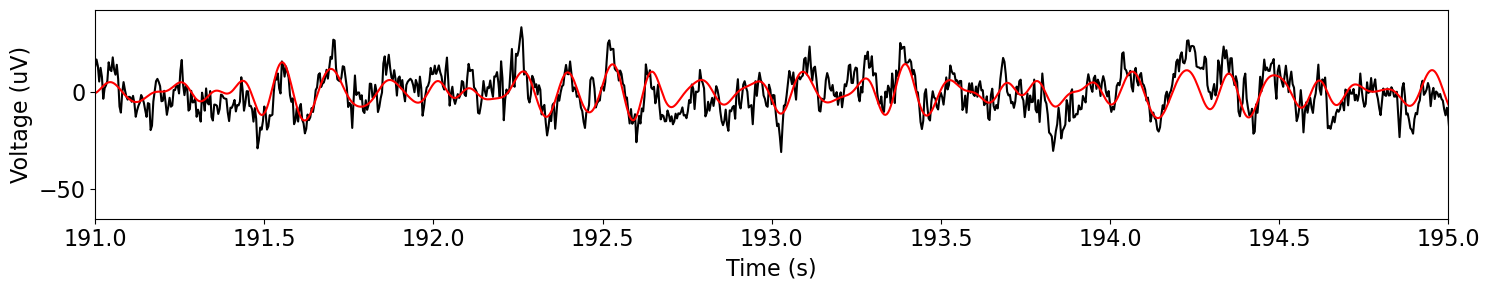

In [22]:
plot_time_series(times, [broadband, narrowband], xlim=[191, 195])

## Compare Data Across Brain States

In [41]:
data_files 

{'awake': 'eeganes07laplac250_detrend_all_t180.mat',
 'low_dose': 'eeganes07laplac250_detrend_all_t3070.mat',
 'high_dose': 'eeganes07laplac250_detrend_all_t4710.mat'}

In [42]:
timeseries = {}
spectra = {}
models = {}

In [43]:
for label, cond_file in data_files.items():
    
    # Load data files & get channel file
    temp_data = loadmat(data_path / cond_file, squeeze_me=True)
    
    # Collect time series
    temp_timeseries = temp_data['y'].T[chind, :]
    timeseries[label] = temp_timeseries
        
    # Compute power spectrum
    _, cond_powers = compute_spectrum(temp_timeseries, fs, **psd_settings)
    spectra[label] = cond_powers
    
    # Fit spectral model and 
    fm.fit(freqs, cond_powers)
    models[label] = fm.copy()

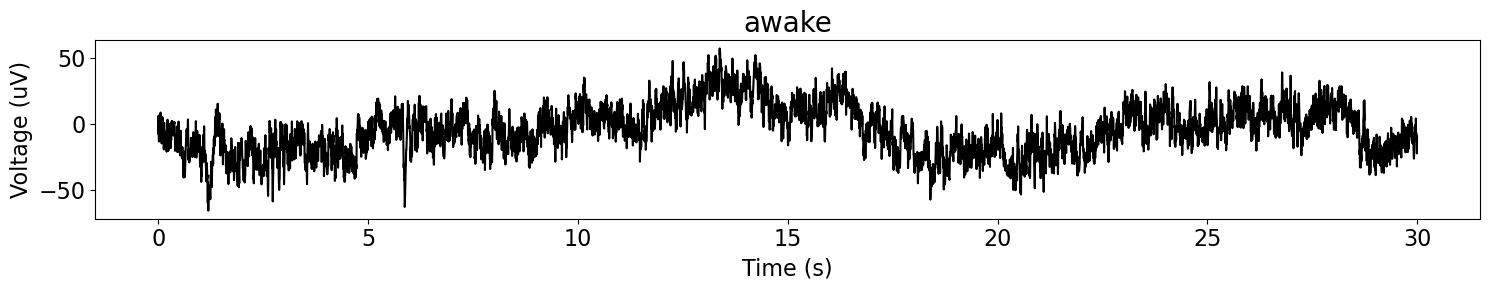

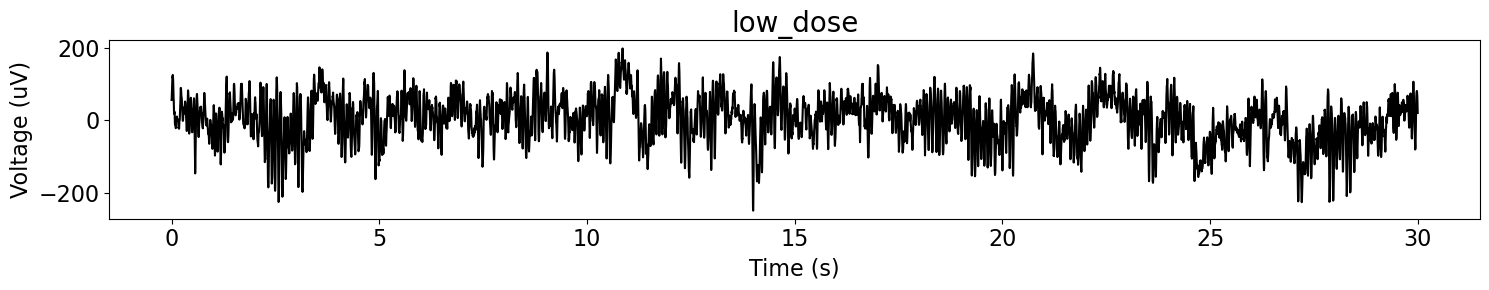

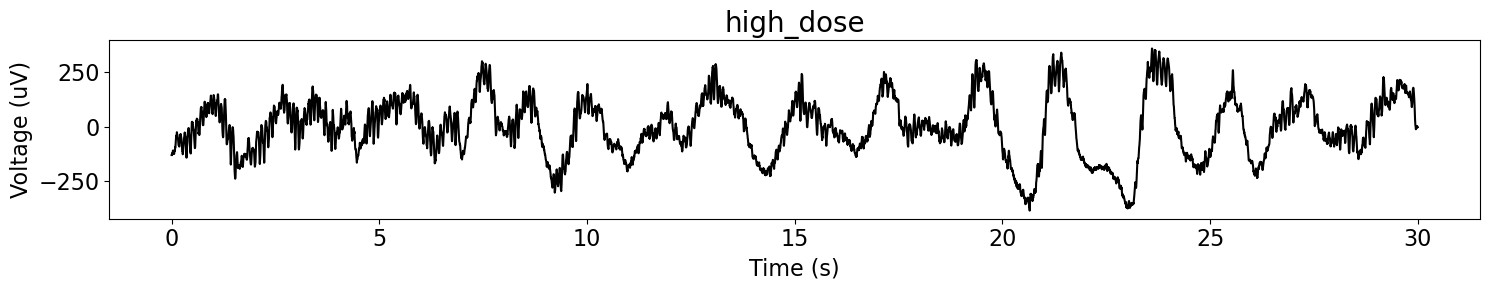

In [53]:
xlim = None
#xlim = [18, 27]
for label, tdata in timeseries.items():
    plot_time_series(times, tdata, title=label, xlim=xlim)

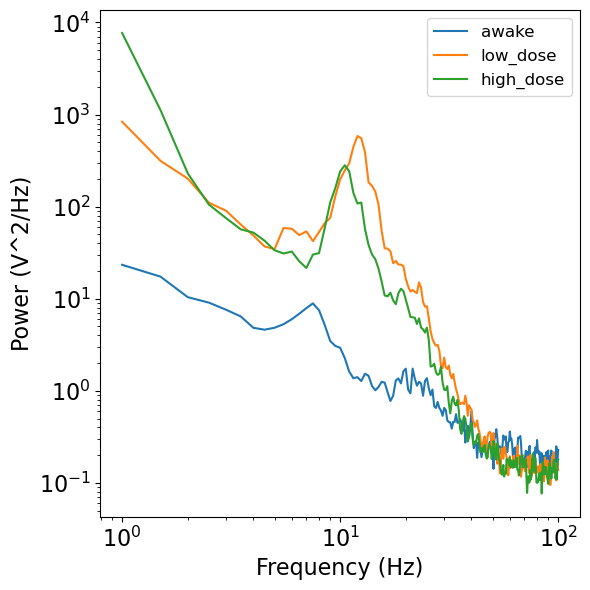

In [33]:
plot_power_spectra(freqs, list(spectra.values()), labels=list(spectra.keys()))

In [27]:
print('Aperiodic Exponents:')
for label, cfm in models.items():
    print('\t{:10s} \t {:2.4f}'.format(label, cfm.get_params('aperiodic', 'exponent')))

Aperiodic Exponents:
	awake      	 1.1874
	low_dose   	 2.0950
	high_dose  	 2.2225


In [28]:
print('Dominant Peak \t\t CF \t\t PW \t\t BW')
for label, cfm in models.items():
    print('\t{:10s} \t {:2.4f} \t {:2.4f} \t {:2.4f}'.format(label, *get_band_peak_fm(cfm, [1, 20])))

Dominant Peak 		 CF 		 PW 		 BW
	awake      	 7.6243 	 0.5161 	 2.8607
	low_dose   	 12.4264 	 1.8617 	 5.5998
	high_dose  	 10.1563 	 1.4516 	 2.8107
